In [16]:
import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('brain-tumor-mri-dataset'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [17]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout
from keras import backend as K
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
image_size = 75
train_folder_path = 'brain-tumor-mri-dataset/Training'
test_folder_path = 'brain-tumor-mri-dataset/Testing'

train_images = []
train_labels = []
for i, label in enumerate(labels):
    folder_path = os.path.join(train_folder_path, label)
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        img = cv2.resize(img, (image_size, image_size))
        train_images.append(img)
        train_labels.append(i)

test_images = []
test_labels = []
for i, label in enumerate(labels):
    folder_path = os.path.join(test_folder_path, label)
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        img = cv2.resize(img, (image_size, image_size))
        test_images.append(img)
        test_labels.append(i)

X_train = np.array(train_images)
Y_train = np.array(train_labels)
X_test = np.array(test_images)
Y_test = np.array(test_labels)

Y_train = Y_train.astype(int)
Y_test = Y_test.astype(int)
    
X_train,Y_train = shuffle(X_train,Y_train,random_state=101)
X_train.shape

(5712, 75, 75, 3)

In [19]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'brain-tumor-mri-dataset/Training'
test_dir = 'brain-tumor-mri-dataset/Testing'

img_height = 75
img_width = 75

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    class_mode='categorical')

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [20]:
X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train,test_size=0.1,random_state=101)

Y_train = tf.keras.utils.to_categorical(Y_train, num_classes = len(labels))
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes = len(labels))

In [21]:
from tensorflow.keras.layers import BatchNormalization
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(75, 75, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='sigmoid'))

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
batch_normalization_2 (Batch (None, 73, 73, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 34, 34, 128)       512       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 17, 128)      

In [23]:
from keras.metrics import Precision, Recall
from keras import backend as K

def f1_score(y_true, y_pred):
    y_true = K.round(y_true)
    y_pred = K.round(y_pred)
    tp = K.sum(y_true * y_pred)
    fp = K.sum ((1-y_true) * y_pred)
    fn = K.sum(y_true * (1-y_pred))
    precison = tp / (tp + fn + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1_score = 2*((precison*recall)/ (precison+recall+K.epsilon()))
    return f1_score

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor= 'val_loss', patience = 3)

from tensorflow.keras.optimizers import RMSprop
model.compile(loss= 'categorical_crossentropy',optimizer= RMSprop(learning_rate= 0.001),metrics=['accuracy', f1_score, Precision(), Recall()])

In [24]:
history = model.fit(X_train, Y_train, batch_size = 64, epochs= 20, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/20
73/73 [==============================] - 7s 70ms/step - loss: 7.9216 - accuracy: 0.7021 - f1_score: 0.9272 - precision_1: 0.4216 - recall_1: 0.9265 - val_loss: 4.7748 - val_accuracy: 0.3327 - val_f1_score: 0.8038 - val_precision_1: 0.2840 - val_recall_1: 0.7802
Epoch 2/20
73/73 [==============================] - 5s 64ms/step - loss: 0.4981 - accuracy: 0.8150 - f1_score: 0.9792 - precision_1: 0.4575 - recall_1: 0.9790 - val_loss: 0.8838 - val_accuracy: 0.7296 - val_f1_score: 0.9635 - val_precision_1: 0.4556 - val_recall_1: 0.9591
Epoch 3/20
73/73 [==============================] - 5s 64ms/step - loss: 0.3509 - accuracy: 0.8671 - f1_score: 0.9863 - precision_1: 0.5126 - recall_1: 0.9862 - val_loss: 0.7118 - val_accuracy: 0.7121 - val_f1_score: 0.9913 - val_precision_1: 0.4221 - val_recall_1: 0.9903
Epoch 4/20
73/73 [==============================] - 5s 64ms/step - loss: 0.2754 - accuracy: 0.8848 - f1_score: 0.9919 - precision_1: 0.5019 - recall_1: 0.9918 - val_loss: 0.8900 - v

In [25]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
image_size = 75
train_folder_path = 'brain-tumor-mri-dataset/Training'
test_folder_path = 'brain-tumor-mri-dataset/Testing'

train_images = []
train_labels = []
for i, label in enumerate(labels):
    folder_path = os.path.join(train_folder_path, label)
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        img = cv2.resize(img, (image_size, image_size))
        train_images.append(img)
        train_labels.append(i)

test_images = []
test_labels = []
for i, label in enumerate(labels):
    folder_path = os.path.join(test_folder_path, label)
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        img = cv2.resize(img, (image_size, image_size))
        test_images.append(img)
        test_labels.append(i)

X_train = np.array(train_images)
Y_train = np.array(train_labels)
X_test = np.array(test_images)
Y_test = np.array(test_labels)

Y_train = Y_train.astype(int)
Y_test = Y_test.astype(int)
    
X_train,Y_train = shuffle(X_train,Y_train,random_state=101)
X_train.shape

(5712, 75, 75, 3)

In [26]:
from sklearn.metrics import classification_report

Y_true = test_generator.classes
Y_pred = model.predict(X_test)
predicted_labels = np.argmax(Y_pred, axis=-1)

print(classification_report(Y_true, predicted_labels, target_names=labels))

              precision    recall  f1-score   support

      glioma       0.90      0.98      0.94       300
  meningioma       0.92      0.83      0.87       306
     notumor       0.97      0.95      0.96       405
   pituitary       0.96      0.99      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



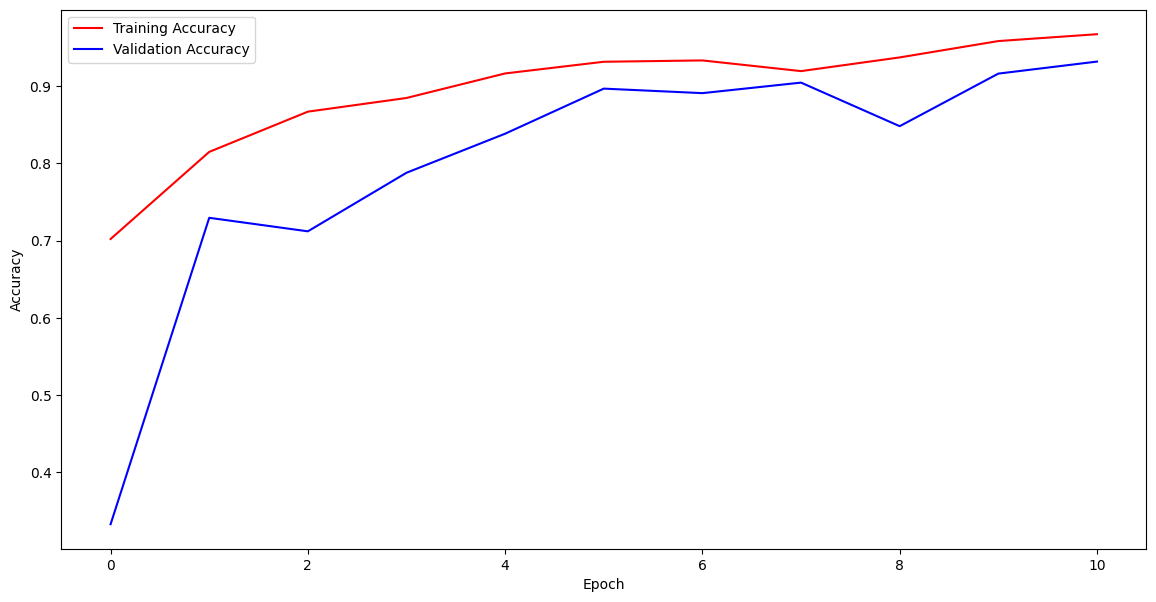

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc,'r',label="Training Accuracy")
plt.plot(epochs, val_acc,'b',label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

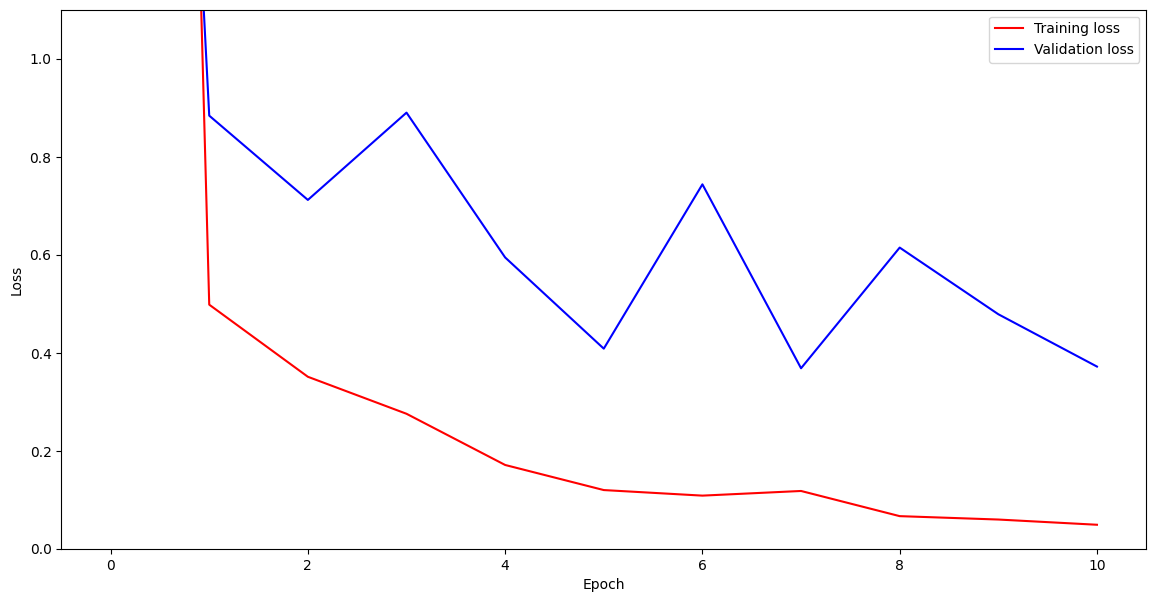

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1.1)
plt.show()

Shape of true_labels: (1311,)
Data type of true_labels: int32
Shape of predicted_labels: (1311,)
Data type of predicted_labels: int64


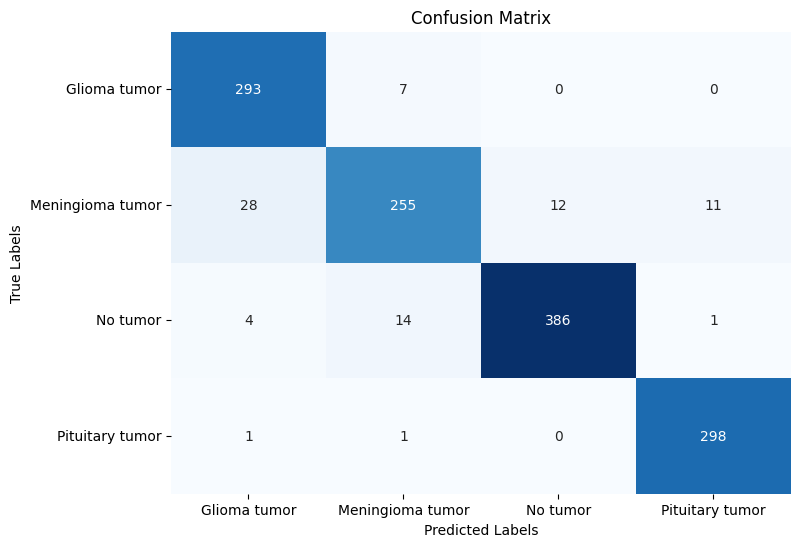

In [29]:
true_labels = test_generator.classes
y_pred = model.predict(X_test)
predicted_labels = np.argmax(y_pred, axis=-1)

print("Shape of true_labels:", true_labels.shape)
print("Data type of true_labels:", true_labels.dtype)
print("Shape of predicted_labels:", predicted_labels.shape)
print("Data type of predicted_labels:", predicted_labels.dtype)

labels = ['Glioma tumor', 'Meningioma tumor', 'No tumor', 'Pituitary tumor']

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)
plt.yticks(rotation=0, ticks=np.arange(len(labels)) + 0.5, labels=labels)
plt.show()